In [1]:
import numpy as np
import pandas as pd
import sklearn
import mlxtend
import scipy
import sys
print(sys.version)
for i in [np, pd, sklearn, mlxtend, scipy]:
    print(i.__name__, i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
numpy 1.18.5
pandas 0.25.1
sklearn 0.21.3
mlxtend 0.15.0.0
scipy 1.5.2


In [219]:
# 시각화 모듈을 불러오고, 한글 폰트를 설정  
import matplotlib as mpl
import matplotlib.font_manager as fm

plt.rc('font', family='NanumBarunGothic') 
mpl.rcParams['axes.unicode_minus'] = False

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

# 문제 개요

삼성전자 A공장은 전기료 효율화를 통한 원가절감 방안을 찾고 있다. 

공장 가동시 일시적인 과부하로 최대수요전력이 증가하면 불리한 기본요금이 산정되고 이는 원가상승 요인이 된다. 

최대수요전력이 높아 지는 시간을 예측하여 선제적으로 수요전력을 조정하는 모델을 개발하고자 한다.

최대수요전력을 바탕으로 시간 단위로 산정한다. 당일 데이터를 바탕으로, 그 다음 날의 최대수요전력을 예측한다. 

이를 바탕으로 다음 날의 생산 원가를 예측한다. 

보유한 데이터는 A공장에서 2021년 1월 1일 ~ 2021년 9월 14일 (9개월) 동안 변압기에 감지센서를 부착하여 

15분 단위로 최대수요전력을 관측한 데이터이다. 

데이터는 2종류이며, ‘elec.csv’ 데이터는 최대수요전력을 측정한 데이터이며,

’info.csv’ 데이터는 측정 당시 기상정보 및 생산량과 인건비율 등의 정보가 포함되어 있다. 

- 데이터 파일: elec.csv (24,642 rows, 4 columns, 데이터셋명-elec)

|컬럼명|내용|타입|
|------|:--|----|
|Date|측정  날짜|문자열|
|DateHour|측정 날짜와 시간|문자열|
|Minute|15분 간격으로 측정<br/>(15분, 30분, 45분, 60분)|문자열|
|Value|최대수요전력(피크전기 사용량)<br/> 최대수요전력이란 공장 내 설치된 변압기를 통해<br/>일정 시간 단위로 누적 계산되는 전력을 의미|정수형|

- 데이터 파일: info.csv (6,168 rows, 9 columns, 데이터셋명-info)

|컬럼명|내용|타입|
|----|:--|-----|
|Date|측정 날짜와 시간|문자열|
|생산량|해당 시점에 생산해야 할 생산량|정수형|
|기온|해당 시점의 기온|실수형|
|풍속|해당 시점의 풍속|실수형|
|습도|해당 시점의 습도|정수형|
|강수량|해당 시점의 강수량|실수형|
|전기요금(계절)|해당시점의 전기요금|실수형|
|공장인원|해당 시점에 공장이 보유한 생산력|실수형|
|인건비|야간 및 주간 인건비에 대한 비율값|실수형|

In [15]:
#방법1
df_elec = pd.read_csv('elec.csv', parse_dates=['Date', 'DateHour'])

#방법2
#df_elec = pd.read_csv('elec.csv')
#df_elec['Date'] = pd.to_datetime(df_elec['Date'])
#df_elec['DateHour'] = pd.to_datetime(df_elec['DateHour'])
df_elec.head()

,Date,DateHour,Minute,Value
0,2021-01-01 00:15:00,2021-01-01 00:00:00,15분,62
1,2021-01-01 00:30:00,2021-01-01 00:00:00,30분,61
2,2021-01-01 00:45:00,2021-01-01 00:00:00,45분,61
3,2021-01-01 01:00:00,2021-01-01 00:00:00,60분,61
4,2021-01-01 01:15:00,2021-01-01 01:00:00,15분,96


In [10]:
df_elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24672 entries, 0 to 24671
Data columns (total 4 columns):
Date        24672 non-null object
DateHour    24672 non-null object
Minute      24672 non-null object
Value       24672 non-null int64
dtypes: int64(1), object(3)
memory usage: 771.1+ KB


In [17]:
df_info = pd.read_csv('info.csv', parse_dates=['Date'])
df_info.head()

,Date,생산량,기온,풍속,습도,강수량,전기요금(계절),공장인원,인건비
0,2021-01-01 00:00:00,0,-3.2,2.4,71,0.0,109.8,0.0,1.5
1,2021-01-01 01:00:00,0,-4.5,1.5,77,0.0,109.8,0.0,1.5
2,2021-01-01 02:00:00,0,-3.9,2.6,58,0.0,109.8,0.0,1.5
3,2021-01-01 03:00:00,0,-4.1,2.6,56,0.0,109.8,0.0,1.5
4,2021-01-01 04:00:00,0,-4.6,2.6,60,0.0,109.8,0.0,1.5


In [18]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6168 entries, 0 to 6167
Data columns (total 9 columns):
Date        6168 non-null datetime64[ns]
생산량         6168 non-null int64
기온          6168 non-null float64
풍속          6165 non-null float64
습도          6168 non-null int64
강수량         6167 non-null float64
전기요금(계절)    6168 non-null float64
공장인원        6151 non-null float64
인건비         6168 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 433.8 KB


# 전처리(Preprocessing)

데이터를 분석하기 위하여 다음에 안내된 순서대로 데이터를 가공 (pre-processing) 하시오. (순서대로 전처리 수행)

## 단계 1 

데이터셋 elec를 이용하여 다음 그림과 같이 재구성하시오.


 ̵ 최대수요전력 (Value)을 시간당 15분 간격으로 관측하여 얻은 4번의 결과 
 
 ̵ DateHour 변수 기준으로 시간당 한 행에 4번 측정결과가 나오도록 재구성함.
 
 ̵ 재구성된 데이터셋은 elec1로 표기(6,168 rows, 5 columns)

|DateHour|15분|30분|45분|60분|
|--------|----|----|----|----|
|2021-01-01 00:00:00|62|61|61|61|
|2021-01-01 01:00:00|96|93|116|113|
|2021-01-01 02:00:00|106|96|106|107|
|2021-01-01 03:00:00|92|110|110|109|
|2021-01-01 04:00:00|108|105|106|108|

In [27]:
# 방법1 pivot
df_elec1 = df_elec.pivot(index='DateHour', columns='Minute', values='Value')
# 방법2 crosstab
#df_elec1 = pd.crosstab(index=df_elec['DateHour'], columns=df_elec['Minute'], 
#                       values=df_elec['Value'], aggfunc='sum')
# 방법3 pivot_table
#df_elec1 = df_elec.pivot_table(index='DateHour', columns='Minute', values='Value', aggfunc='sum')
df_elec1.head()

Minute,15분,30분,45분,60분
DateHour,,,,
2021-01-01 00:00:00,62,61,61,61
2021-01-01 01:00:00,96,93,116,113
2021-01-01 02:00:00,106,96,106,107
2021-01-01 03:00:00,92,110,110,109
2021-01-01 04:00:00,108,105,106,108


## 단계 2

데이터셋 elec1의 DateHour 변수를 이용하여 아래의 파생변수를 생성한다.

̵ 요일명(DayName): DateHour 변수에서 요일명을 숫자로 추출, 0(월)~6(일)으로 반환

̵ 시간(Hour): DateHour 변수에서 시간 추출

̵ 오전/오후(AM): 생성한 시간(Hour) 변수를 기준으로 

 12시 전( < 12:00)은 오전(0), 이후(>= 12:00)는 오후(1)로 표기, 이때 표기는 숫자 0, 1로 표기
 
̵ 주말유무(Weekend_yn): 생성한 요일명(DayName) 변수를 이용하여 5,6이면 1(주말), 그외는 0(평일) 로 표기

̵ 공휴일(Holiday_yn): 다음은 공휴일 목록임

  ["2021-01-01", "2021-02-11", "2021-02-12", "2021-03-01", "2021-05-05", "2021-05-19", "2021-08-16"], 

  목록에 해당하면 1, 아니면 0로 표기한다. DateHour의 일자를 기준으로 판별한다.
 
̵ 최대수요전력 평균(Avg): 시간당 15분 간격(15분, 30분, 45분, 60분)으로 측정한 최대수요전력 (Value)의 평균값

̵ 최대수요전력 합계(TotalHour): 시간당 15분 간격(15분, 30분, 45분, 60분)으로 측정한 최대수요전력 (Value)의 총합

In [120]:
df_elec1['DayName'] = df_elec1.index.weekday
df_elec1['Hour'] = df_elec1.index.hour
df_elec1['AM'] = df_elec1.index.hour < 12
df_elec1['Weekend_yn'] = df_elec1.index.weekday.isin([5, 6]).astype('int8')
holi_list = ["2021-01-01", "2021-02-11", "2021-02-12", "2021-03-01", "2021-05-05", "2021-05-19", "2021-08-16"]
df_elec1['Holiday_yn'] = df_elec1.index.strftime('%Y-%m-%d').isin(holi_list).astype('int8')
min_cols = ['15분', '30분', '45분', '60분']
df_elec1['Avg'] = df_elec1[min_cols].mean(axis=1)
df_elec1['TotalHour'] = df_elec1[min_cols].sum(axis=1)

In [59]:
#df_elec1['DayName'] = df_elec1.reset_index()['DateHour'].dt.weekday
#df_elec1['Hour'] = df_elec1.reset_index()['DateHour'].dt.weekday
#df_elec1['AM'] = df_elec1.reset_index()['DateHour'].dt.weekday
#df_elec1['Weekend_yn'] = df_elec1.index.weekday.isin([5, 6]).astype('int8')

## 단계 3
    
info데이터셋에 결측치가 존재한다. 이 때 발생된 결측치들은 0으로 변경하시오. 

  ̵ 풍속, 강수량은 바람이 불지 않는 경우, 비가 오지 않는 경우 기록되지 않는 경우가 존재함, 이는 0의 의미임

  ̵ 공장인원의 경우 생산량이 없다던가 인력이 필요하지 않은 경우 기록되지 않는 경우가 존재함, 이는 0의 의미임

  ̵ 결측치를 처리한 후 데이터셋명은 info1로 표기함


In [63]:
df_info1 = df_info.fillna(0)

## 단계 4

elec1와 info1 데이터프레임을 결합하시오. 

결합 시 elec1데이터셋 에서는 DateHour 변수, info1데이터셋 에서는 Date 변수를 기준으로 inner join하시오.


 ̵ elec1 데이터셋 기준으로 info1 데이터셋 결합
 
 ̵ 결합 방식: inner join, elec1.DateHour == info1.Date
 
 ̵ 결합 후 Date 변수 제거
 
 ̵ 결합 후 생성된 데이터셋명 basetable1로 표기(6,168 rows, 20 columns)


In [121]:
# 방법 1 join
df_basetable1 =  df_elec1.join(df_info1.set_index('Date'), how='inner')
# 방법 2 merge
#df_basetable1 = df_elec1.merge(df_info1, how='inner', left_on='DateHour', right_on='Date')\
#                        .rename(columns={'Date':'DateHour'}).set_index('DateHour')
df_basetable1.head()

,15분,30분,45분,60분,DayName,Hour,AM,Holiday_yn,Avg,TotalHour,Weekend_yn,생산량,기온,풍속,습도,강수량,전기요금(계절),공장인원,인건비
DateHour,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,62,61,61,61,4,0,True,1,61.25,245,0,0,-3.2,2.4,71,0.0,109.8,0.0,1.5
2021-01-01 01:00:00,96,93,116,113,4,1,True,1,104.50,418,0,0,-4.5,1.5,77,0.0,109.8,0.0,1.5
2021-01-01 02:00:00,106,96,106,107,4,2,True,1,103.75,415,0,0,-3.9,2.6,58,0.0,109.8,0.0,1.5
2021-01-01 03:00:00,92,110,110,109,4,3,True,1,105.25,421,0,0,-4.1,2.6,56,0.0,109.8,0.0,1.5
2021-01-01 04:00:00,108,105,106,108,4,4,True,1,106.75,427,0,0,-4.6,2.6,60,0.0,109.8,0.0,1.5


# 문제 1

basetable1을 이용하여 다음 질문에 답하시오.

## 단계 1-1

시간당 최대수요전력 합계(TotalHour) 기준으로 최대값과 최소값이 차이값을 구하고, 이 값을 A라고 한다.

In [84]:
mx, mn = df_basetable1['TotalHour'].agg(['max', 'min'])
A = mx - mn
A

830

## 단계 1-2 

일별 기준(DateHour 변수 사용)으로 시간당 최대수요전력 합계(TotalHour) 최대값을 찾는다. 

일별로 최대값이 첫 번째로 빈번하게 발생하는 시간(Hour)을 B, 

두 번째로 빈번하게 발생하는 시간(Hour)을 C라고 한다. 

하루에 최대값에 해당하는 시간(Hour)이 여러 번 나올 수 있음을 고려하라.

In [103]:
B, C = df_basetable1.loc[df_basetable1.groupby(df_basetable1.index.date)['TotalHour']\
                  .transform(lambda x: x.max() == x), 'Hour']\
                  .value_counts().iloc[:2].index
B, C

(8, 11)

## 단계 1-3

일별 기준(DateHour 변수 사용)으로 시간당 최대수요전력 합계(TotalHour) 의 범위(최대값-최소값)가 가장 큰 값을 찾고 

이 값을 D라고 한다.

In [104]:
df_basetable1.head()

,15분,30분,45분,60분,DayName,Hour,AM,Holiday_yn,Avg,TotalHour,생산량,기온,풍속,습도,강수량,전기요금(계절),공장인원,인건비
DateHour,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,62,61,61,61,4,0,True,True,61.25,245,0,-3.2,2.4,71,0.0,109.8,0.0,1.5
2021-01-01 01:00:00,96,93,116,113,4,1,True,True,104.50,418,0,-4.5,1.5,77,0.0,109.8,0.0,1.5
2021-01-01 02:00:00,106,96,106,107,4,2,True,True,103.75,415,0,-3.9,2.6,58,0.0,109.8,0.0,1.5
2021-01-01 03:00:00,92,110,110,109,4,3,True,True,105.25,421,0,-4.1,2.6,56,0.0,109.8,0.0,1.5
2021-01-01 04:00:00,108,105,106,108,4,4,True,True,106.75,427,0,-4.6,2.6,60,0.0,109.8,0.0,1.5


In [117]:
df_tmp = df_basetable1.groupby(df_basetable1.index.date)['TotalHour']\
                    .agg(['max', 'min']).rename(columns={'max': 'mx', 'min': 'mn'})
D = (df_tmp['mx'] - df_tmp['mn']).max()

## 단계 1-4

공휴일과 주말을 제외한 평일 데이터만 추출을 한 후, 

일별 기준으로 시간당 최대수요전력 합계(TotalHour)의 범위(최대값-최소값)가 가장 큰 일자의 DayName을 E라고 한다.



In [133]:
df_tmp = df_basetable1.loc[~df_basetable1[['Weekend_yn', 'Holiday_yn']].any(axis=1)]
df_tmp = df_tmp.groupby(df_tmp.index.date)['TotalHour']\
                .agg(['max', 'min']).rename(columns={'max': 'mx', 'min': 'mn'})
df_tmp['diff'] = df_tmp['mx'] - df_tmp['mn']
E = df_tmp['diff'].idxmax().weekday()

In [134]:
A + B + C + D + E

1555

A + B + C + D + E를 적으시오.

**1555**

# 문제 2

최대수요전력 평균(Avg) 값이 오전/오후에 따라 차이가 있는지 검정하시오.

##  단계 2-1

basetable1 에서 공휴일과 주말을 제외하고 prob2 데이터프레임을 만든다.

- prob2에서 시간(Hour)이 8과 11사이 (8, 11 포함) 또는 13과 16 (13, 16 포함) 사이의 행들만 남긴다.

- prob2에서 Avg가 130이상인 행들만을 남긴다.

Hint] 최종 1233개 행만 남는다.


In [135]:
df_prob2 = df_basetable1.loc[~df_basetable1[['Weekend_yn', 'Holiday_yn']].any(axis=1)].copy()
df_prob2 = df_prob2.loc[df_prob2['Hour'].between(8, 11, inclusive=True) |
            df_prob2['Hour'].between(13, 16, inclusive=True)].query('Avg >= 130').copy()

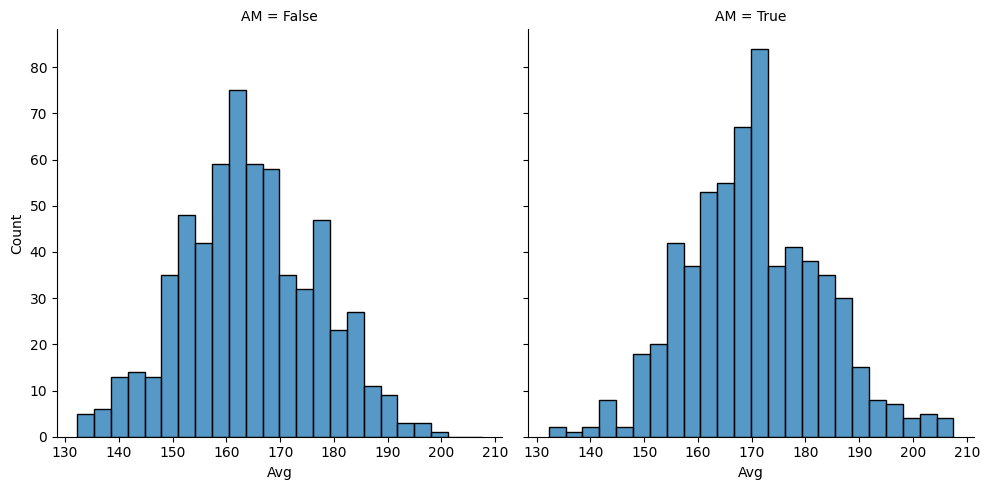

In [152]:
sns.displot(data=df_prob2, x='Avg', col='AM')

## 단계 2-2

오전(AM = 0) 인 행들을 대상으로 Avg에 대하여 Shapiro-Wilk 검정을 사용하여 정규성 검정한다. 

검정 결과에서 p-value를 A라고 한다.

Hint] scipy.stats.shapiro


In [172]:
from scipy.stats import shapiro
A = shapiro(df_prob2.loc[df_prob2['AM'] == 0, 'Avg']).pvalue
A

0.043661389499902725

## 단계 2-3

오후(AM = 1) 인 행들을 대상으로 Avg에 대하여 Shapiro-Wilk 검정을 사용하여 정규성 검정한다. 

검정 결과에서 p-value를 B라고 한다.

In [173]:
B = shapiro(df_prob2.loc[df_prob2['AM'] == 1, 'Avg']).pvalue
B

0.026428762823343277

## 단계 2-4

오전/오후에 따라 Avg의 모평균에 차이가 있는지 검정을 한다. 검정 통계량의 절대값을 C라고 한다. 

검정 방법은 T-검정을 사용하며, Bartlett 검정을 하고 결과를 T-검정 시 반영한다. 검정 결과에서 검정통계량의 절대값을 C라고 한다.

Hint] scipy.stats.ttest_ind, 
scipy.stats.bartlett


In [174]:
from scipy.stats import ttest_ind
from scipy.stats import bartlett

eq_var =  bartlett(df_prob2.loc[df_prob2['AM'] == 0, 'Avg'], 
        df_prob2.loc[df_prob2['AM'] == 1, 'Avg']).pvalue > 0.05
C = ttest_ind(df_prob2.loc[df_prob2['AM'] == 0, 'Avg'],
         df_prob2.loc[df_prob2['AM'] == 1, 'Avg'], equal_var = eq_var)
C = abs(C.statistic)
C

8.27772409322812

## 단계 2-5

단계 2-2와 2-3의 결과에서 유의 수준을 5%라고 한다면, T-검정의 가정을 만족한다면 D 값은 1 아니면 0으로한다.

In [175]:
D = 0

## 단계 2-6

오전/오후에 따라 Avg의 모평균에 차이가 있는지 Mann-Whiteny U 검정을 사용하여 검정한다. 

검정 결과 검정통계량을 E값으로 한다.

Hint] scipy.stats.mannwhitneyu


In [176]:
from scipy.stats import mannwhitneyu

E = mannwhitneyu(df_prob2.loc[df_prob2['AM'] == 0, 'Avg'],
            df_prob2.loc[df_prob2['AM'] == 1, 'Avg']).statistic
E

140292.5

In [177]:
A + B + C + D + E

140300.84781424556

A + B + C + D + E를 소수점 넷째 자리에서 반올림하여 셋째 자리까지 적으시오

**140300.848**

## 문제 3


DateHour를 기준으로 DateHour의 다음날 같은 시각의 최대전력사용량을 예측하려고 한다.


In [180]:
df_basetable1['TotalHour'].shift(-24)

DateHour
2021-01-01 00:00:00    253.0
2021-01-01 01:00:00    418.0
2021-01-01 02:00:00    415.0
2021-01-01 03:00:00    421.0
2021-01-01 04:00:00    427.0
                       ...  
2021-09-14 19:00:00      NaN
2021-09-14 20:00:00      NaN
2021-09-14 21:00:00      NaN
2021-09-14 22:00:00      NaN
2021-09-14 23:00:00      NaN
Name: TotalHour, Length: 6168, dtype: float64

In [181]:
df_basetable1['TotalHour'].iloc[24:]

DateHour
2021-01-02 00:00:00    253
2021-01-02 01:00:00    418
2021-01-02 02:00:00    415
2021-01-02 03:00:00    421
2021-01-02 04:00:00    427
                      ... 
2021-09-14 19:00:00    613
2021-09-14 20:00:00    512
2021-09-14 21:00:00    513
2021-09-14 22:00:00    443
2021-09-14 23:00:00    439
Name: TotalHour, Length: 6144, dtype: int64

## 단계 3-1 

basetable1에 아래 그림과 같이 다음날 같은 시각의 TotalHour를 파생 변수로 생성한다. 

파생 변수의 이름은 target으로 한다. target에 결측치가 있는 행은 모두 제거하여 prob3 데이터셋을 만든다.

In [185]:
df_prob3 = df_basetable1.assign(
    target=lambda x: x['TotalHour'].shift(-24)
).dropna()
df_prob3.head()

,15분,30분,45분,60분,DayName,Hour,AM,Holiday_yn,Avg,TotalHour,Weekend_yn,생산량,기온,풍속,습도,강수량,전기요금(계절),공장인원,인건비,target
DateHour,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,62,61,61,61,4,0,True,1,61.25,245,0,0,-3.2,2.4,71,0.0,109.8,0.0,1.5,253.0
2021-01-01 01:00:00,96,93,116,113,4,1,True,1,104.50,418,0,0,-4.5,1.5,77,0.0,109.8,0.0,1.5,418.0
2021-01-01 02:00:00,106,96,106,107,4,2,True,1,103.75,415,0,0,-3.9,2.6,58,0.0,109.8,0.0,1.5,415.0
2021-01-01 03:00:00,92,110,110,109,4,3,True,1,105.25,421,0,0,-4.1,2.6,56,0.0,109.8,0.0,1.5,421.0
2021-01-01 04:00:00,108,105,106,108,4,4,True,1,106.75,427,0,0,-4.6,2.6,60,0.0,109.8,0.0,1.5,427.0


## 단계 3-2 

학습용과 테스트용 데이터셋을 2021년 8월 14일 전과 이후로 분리

. prob3_train: DateHour 변수 기준으로 2021년 8월 14일 전(8월 14일 미포함) 데이터 (행의 수: 5400개)

. prob3_test: DateHour 변수 기준으로 2021년 8월 14일 이후(8월 14일 포함) 데이터 (행의 수: 744 개)


In [193]:
df_prob3_train = df_prob3.loc[df_prob3.index.strftime('%Y-%m-%d') < '2021-08-14'].copy()
df_prob3_test = df_prob3.loc[df_prob3.index.strftime('%Y-%m-%d') >= '2021-08-14'].copy()
df_prob3_train.shape, df_prob3_test.shape

((5400, 20), (744, 20))

## 단계 3-3

결정트리 회귀모델(Decision Tree Regression Model)을 사용하여 target을 예측하는 모델을 prob3_train으로 학습시킨다. 

요건은 다음과 같다.


성능 측정 지표: $MAE(Y, \hat{y})=\sum^n_{i=1}|y_i - \hat{y_i}|$

입력 변수: 15분, 30분, 45분, 60분, DayName, Hour, AM, Weekend_yn, Holiday_yn, Avg, TotalHour, 

           생산량, 기온, 풍속, 습도, 강수량, 전기요금(계절), 공장인원, 인건비
※ 입력 변수의 순서는 반드시 나열한 순서로 해야 함.

대상 변수: target

결정 트리 구성 요건:

   sklearn.tree.DecisionTreeRegressor, random_state=123
   
   |하이퍼 파라미터|값|
   |-|-|
   |트리의 최대 깊이|10|
   |리프 노드(Leaf Node)의 최소 샘플 수|4|
   
학습한 모델에서 측정한 입력 변수 중에서 가장 중요도가 높은 입력 변수의 입력 순서를 A (순서는 1부터 시작) 라고 한다. 

결정 트리의 prob4_test에 대한 성능을 B라고 한다. 


In [197]:
X_cols = [
    '15분', '30분', '45분', '60분', 'DayName', 'Hour', 'AM', 'Weekend_yn', 'Holiday_yn', 'Avg', 'TotalHour',
    '생산량', '기온', '풍속', '습도', '강수량', '전기요금(계절)', '공장인원', '인건비'
]
from sklearn.tree import DecisionTreeRegressor
reg_dt = DecisionTreeRegressor(
    random_state=123,
    max_depth=10,
    min_samples_leaf=4
)
reg_dt.fit(df_prob3_train[X_cols], df_prob3_train['target'])

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=123, splitter='best')

In [202]:
A = np.argmax(reg_dt.feature_importances_) + 1
A

5

c:\users\pc\python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\pc\python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\pc\python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\pc\python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\pc\python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\pc\python37\lib\site-packages\IPython

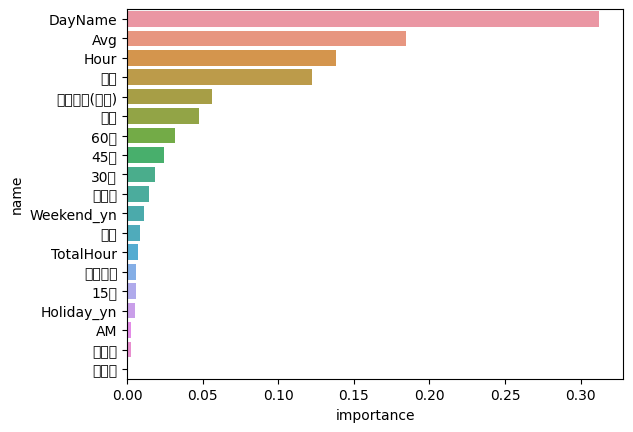

In [220]:
df_i = pd.DataFrame({'name': X_cols, 'importance': reg_dt.feature_importances_})\
                    .sort_values('importance', ascending=False)
sns.barplot(data=df_i, x='importance', y='name')
plt.show()

In [207]:
from sklearn.metrics import mean_absolute_error
B = mean_absolute_error(df_prob3_test['target'], reg_dt.predict(df_prob3_test[X_cols]))
B

37.27394388956255

## 단계 3-4

결정트리 대신에 랜덤포레스트 회귀모델(Random-Forest Regression Model)을 사용한다. 

랜덤포레스트 회귀모델을 구성하는 결정트리 수는 50개로 하고, 다른 설정은 결정트리와 같다. 

prob4_train으로 학습하고 prob4_test에 대한 성능을 C라고 한다.

In [211]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor(
    n_estimators=50,
    random_state=123,
    max_depth=10,
    min_samples_leaf=4
)
reg_rf.fit(df_prob3_train[X_cols], df_prob3_train['target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [213]:
C = mean_absolute_error(df_prob3_test['target'], reg_rf.predict(df_prob3_test[X_cols]))
C

33.827583781718324

In [214]:
A + B + C

76.10152767128088

A + B + C를 소수점 넷째 자리에서 반올림하여 셋째 자리까지 적으시오

**76.102**

## 문제 4

DateHour를 기준으로 동일한 시각의 n일 이전의 TotalHour를 파생 변수 lag_n이라고 한다. 

예를 들어 DateHour가 2021-01-07 00:00:00이라면, lag_1은 2021-01-06 00:00:00의 TotalHour값인 96이 된다. 

In [223]:
df_prob3['TotalHour'].shift(24).iloc[24:]

DateHour
2021-01-02 00:00:00    245.0
2021-01-02 01:00:00    418.0
2021-01-02 02:00:00    415.0
2021-01-02 03:00:00    421.0
2021-01-02 04:00:00    427.0
                       ...  
2021-09-13 19:00:00     92.0
2021-09-13 20:00:00     93.0
2021-09-13 21:00:00    100.0
2021-09-13 22:00:00     92.0
2021-09-13 23:00:00     91.0
Name: TotalHour, Length: 6120, dtype: float64

In [224]:
df_prob3['TotalHour']

DateHour
2021-01-01 00:00:00    245
2021-01-01 01:00:00    418
2021-01-01 02:00:00    415
2021-01-01 03:00:00    421
2021-01-01 04:00:00    427
                      ... 
2021-09-13 19:00:00    592
2021-09-13 20:00:00    483
2021-09-13 21:00:00    490
2021-09-13 22:00:00    440
2021-09-13 23:00:00    431
Name: TotalHour, Length: 6144, dtype: int64

## 단계 4-1

prob3에 lag_1 ~ lag_6까지의 6개의 파생 변수를 추가하여 prob4를 만든다. 

prob4에 lag_1~6까지 하나라도 결측치가 있다면 삭제한다.

In [225]:
c_list = [df_prob3]
for i in range(1, 7):
    c_list.append(df_prob3['TotalHour'].shift(24 * i).rename('lag_{}'.format(i)))

In [228]:
df_prob4 = pd.concat(c_list, axis=1).dropna()
df_prob4.head()

,15분,30분,45분,60분,DayName,Hour,AM,Holiday_yn,Avg,TotalHour,...,전기요금(계절),공장인원,인건비,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
DateHour,,,,,,,,,,,,,,,,,,,,,
2021-01-07 00:00:00,22,22,22,25,3,0,True,0,22.75,91,...,109.8,0.000000,1.5,252.0,96.0,96.0,271.0,88.0,253.0,245.0
2021-01-07 01:00:00,26,22,22,22,3,1,True,0,23.00,92,...,109.8,0.369565,1.5,396.0,85.0,85.0,432.0,99.0,418.0,418.0
2021-01-07 02:00:00,22,21,21,22,3,2,True,0,21.50,86,...,109.8,0.000000,1.5,411.0,85.0,85.0,439.0,88.0,415.0,415.0
2021-01-07 03:00:00,22,22,22,23,3,3,True,0,22.25,89,...,109.8,0.629213,1.5,398.0,90.0,90.0,426.0,88.0,421.0,421.0
2021-01-07 04:00:00,22,26,26,23,3,4,True,0,24.25,97,...,109.8,2.865979,1.5,420.0,93.0,93.0,435.0,95.0,427.0,427.0


## 단계 4-2

학습용과 테스트용 데이터셋을 2021년 8월 14일 전과 이후로 분리

. prob4_train: DateHour 변수 기준으로 2021년 8월 14일 전(8월 14일 미포함) 데이터 (행의 수: 5256개)

. prob4_test: DateHour 변수 기준으로 2021년 8월 14일 이후(8월 14일 포함) 데이터 (행의 수: 744 개)

In [229]:
df_prob4_train = df_prob4.loc[df_prob4.index.strftime('%Y-%m-%d') < '2021-08-14'].copy()
df_prob4_test = df_prob4.loc[df_prob4.index.strftime('%Y-%m-%d') >= '2021-08-14'].copy()
df_prob4_train.shape, df_prob4_test.shape

((5256, 26), (744, 26))

## 단계 4-3

prob4_train에서 TotalHour와 lag_1~6 를 표준화하고, 

prob4_train의 표준화 설정으로 prob4_test의 TotalHour와 lag_1~6를 표준화한다.

In [231]:
from sklearn.preprocessing import StandardScaler
X_cols_prob4 = ['TotalHour'] + ['lag_{}'.format(i) for i in range(1, 7)]
std_scaler = StandardScaler()
df_prob4_train[X_cols_prob4] = std_scaler.fit_transform(df_prob4_train[X_cols_prob4])
df_prob4_test[X_cols_prob4] = std_scaler.transform(df_prob4_test[X_cols_prob4])

In [233]:
df_prob4_train[X_cols_prob4].agg(['mean', 'std'])

,TotalHour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
mean,9.463088e-17,0.000000,-8.246405e-17,2.433366e-17,-1.067977e-16,-3.920422e-17,8.922340e-17
std,1.000095e+00,1.000095,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00,1.000095e+00


In [234]:
df_prob4_test[X_cols_prob4].agg(['mean', 'std'])

,TotalHour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
mean,0.040191,0.065556,0.138973,0.194793,0.202593,0.192817,0.130666
std,1.020678,1.014981,0.998460,0.991484,0.990697,1.003863,1.027020


## 단계 4-4

SVR 모델을 아래 요건에 3가지 커널(Kernel)로 prob4_train을 학습하고 

prob4_test로 성능을 측정한다. 

그 중 가장 좋은 성능을 보인 커널의 번호를 A, 그 때의 성능을 B라고 한다.

성능 측정 지표: $MAE(Y, \hat{y})=\sum^n_{i=1}|y_i - \hat{y_i}|$

입력 변수: TotalHour, lag_1 ~ 6

대상 변수: target

요건] sklearn.svm.SVR, C=10


1: $k(x_i,x_j)=\langle x_i,x_j \rangle$

2: $k(x_i,x_j)=(\gamma \langle x_i,x_j \rangle +1)^2,\gamma=0.1$

3: $k(x_i,x_j)=exp⁡(||-\gamma ||x_i-x_j||^2 ),\gamma=0.1$

 $\langle x,x' \rangle:x,x'$ 의 내적,$||x_i-x_j||^2$:L2-norm


In [241]:
from sklearn.svm import SVR

param_list = [
    {'kernel': 'linear', 'C': 10},
    {'kernel': 'poly', 'degree': 2, 'coef0': 1, 'gamma': 0.1, 'C': 10},
    {'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
]
for param in param_list:
    svr = SVR(**param)
    svr.fit(df_prob4_train[X_cols_prob4], df_prob4_train['target'])
    print(param, mean_absolute_error(df_prob4_test['target'], svr.predict(df_prob4_test[X_cols_prob4])))


{'kernel': 'linear', 'C': 10} 32.88361068048479
{'kernel': 'poly', 'degree': 2, 'coef0': 1, 'gamma': 0.1, 'C': 10} 32.04119565841312
{'kernel': 'rbf', 'gamma': 0.1, 'C': 10} 30.017658858928023


In [243]:
A, B = 3, 30.017658858928023

## 단계 4-5

퍼셉트론 회귀모델을 다음과 같이 3가지 설정으로 prob4_train으로 학습하고, 

prob4_test로 성능을 측정한다. 

가장 좋은 성능을 보인 경우의 번호 C, 그 때의 성능을 D라고 한다.


성능 측정 지표: MAE(y,y ̂ )=∑_(i=1)^n▒|y_i-(y_i ) ̂ | 

입력 변수: TotalHour, lag_1 ~ 6

대상 변수: target

요건] sklearn.neural_network.MLPRegressor, 

learing_rate_init=0.05, random_state=123, max_iter=500


|No.|은닉층의 수|은닉층의 활성화 함수|
|---|---------|-------------|
|1|[8]|relu|
|2|[8, 4]|relu|
|3|[8, 4]|sigmoid|




In [251]:
from sklearn.neural_network import MLPRegressor

param_list = [
    {'hidden_layer_sizes': [8], 'activation': 'relu'}, 
    {'hidden_layer_sizes': [8, 4], 'activation': 'relu'},
    {'hidden_layer_sizes': [8, 4], 'activation': 'logistic'}
]
for param in param_list:
    reg_nn = MLPRegressor(learning_rate_init=0.05, random_state=123, max_iter=500, **param)
    reg_nn.fit(df_prob4_train[X_cols_prob4], df_prob4_train['target'])
    print(param, mean_absolute_error(df_prob4_test['target'], reg_nn.predict(df_prob4_test[X_cols_prob4])))

{'hidden_layer_sizes': [8], 'activation': 'relu'} 39.682836715413366
{'hidden_layer_sizes': [8, 4], 'activation': 'relu'} 38.57988917988747
{'hidden_layer_sizes': [8, 4], 'activation': 'logistic'} 43.740119906766495


In [252]:
C, D = 2, 38.57988917988747

In [253]:
A + B + C + D

73.59754803881549

**73.60**

# 문제 5

info에서 기온, 풍속, 습도 강수량 데이터에서 이상치를 탐색하고자 한다.

## 단계 5-1

info1에서 기온, 풍속, 습도, 강수량 만을 떼어 weather1 데이터프레임을 만든다.

In [255]:
X_cols_prob5 = ['기온', '풍속', '습도', '강수량']
df_weather1 = df_info1[X_cols_prob5].copy()
df_weather1.head()

,기온,풍속,습도,강수량
0,-3.2,2.4,71,0.0
1,-4.5,1.5,77,0.0
2,-3.9,2.6,58,0.0
3,-4.1,2.6,56,0.0
4,-4.6,2.6,60,0.0


## 단계 5-2

weather1의 기온, 풍속, 습도, 강수량을 표준화 한다.


In [256]:
from sklearn.preprocessing import StandardScaler

df_weather1[X_cols_prob5] = StandardScaler().fit_transform(df_weather1[X_cols_prob5])
df_weather1.head()

,기온,풍속,습도,강수량
0,-2.085903,0.289680,0.039195,-0.233447
1,-2.227830,-0.483098,0.300129,-0.233447
2,-2.162325,0.461409,-0.526162,-0.233447
3,-2.184160,0.461409,-0.613140,-0.233447
4,-2.238748,0.461409,-0.439184,-0.233447


In [257]:
df_weather1[X_cols_prob5].agg(['mean', 'std'])

,기온,풍속,습도,강수량
mean,-1.474537e-16,-1.843172e-17,-2.580441e-16,4.607930e-17
std,1.000081e+00,1.000081e+00,1.000081e+00,1.000081e+00


## 단계 5-3

DBSCAN 군집화를 입실론(epsilon) 반경을 0.5, 주변 영역에 포함하는 최소 샘플수를 7로하여 군집화를 수행 한다. 

weather1에 DBSCAN 결과에서 소속 군집이 없는 샘플들을 이상점으로 간주한다. 

이상점 여부를 파생변수 outlier_dbscan로 하여 weather1에 추가한다. (소속 군집이 있으면: False, 없으면 True)

  Hint] sklearn.cluster.DBSCAN, algorithm=’brute’


In [268]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
    eps=0.5, # 군집화를 입실론(epsilon) 반경을 0.5, 
    min_samples=7, # 주변 영역에 포함하는 최소 샘플수를 7로하여 군집화를 수행 한다.
    algorithm='brute'
)
dbscan.fit(df_weather1[X_cols_prob5])

DBSCAN(algorithm='brute', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=7, n_jobs=None, p=None)

In [271]:
df_weather1['outlier_dbscan'] = dbscan.labels_ == -1

## 단계 5-4

IsolationForest를 사용하여 weather1의 이상점을 탐색한다. 

학습시 비복원 추출은 하지 않고, 트리의 수는 30개를 사용한다. 

IsolationForest으로 탐지한 이상점 여부는 파생변수 outlier_isof로 하여 weather1에 추가한다. (이상치라면 True, 아니면 False)

Hint] sklearn.ensemble.IsolationForest, 

random_state=123, contamination=’auto’, behaviour=’auto’


In [279]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest(
    bootstrap=False, #학습시 비복원 추출은 하지 않고, 
    n_estimators=30, #트리의 수는 30개를 사용한다.
    random_state=123, contamination='auto', behaviour='auto'
)
isf.fit(df_weather1[X_cols_prob5])
df_weather1['outlier_isof'] = isf.predict(df_weather1[X_cols_prob5]) == -1

## 단계 5-5

LocalOutlierFactor를 사용하여 weather1의 이상점을 탐색한다. 

관찰할 주변의 샘플은 10개이다. 그리고, 샘플간의 거리는 유클리디언 거리를 사용한다. 

LocalOutlierFactor로 탐지한 이상 여부를 outlier_lof로 하여 weather1에 추가한다.

Hint] sklearn.neighbors.LocalOutlierFactor,
 contamination=’auto’


In [287]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(
    n_neighbors=10, #관찰할 주변의 샘플은 10개이다
    metric='minkowski', p=2, #샘플간의 거리는 유클리디언 거리
    contamination='auto'
)
result = lof.fit_predict(df_weather1[X_cols_prob5])
df_weather1['outlier_lof'] = result == -1

## 단계 5-6 

outlier_dbscan가 True인 행의 개수를 A, outlier_isof가 True인 행의 개수 B
,  outlier_lof가 True인 행의 개수 C 이다.


In [295]:
df_weather1[['outlier_dbscan', 'outlier_isof', 'outlier_lof']].sum(axis=0)

outlier_dbscan     210
outlier_isof      1108
outlier_lof         83
dtype: int64

In [293]:
A, B, C = df_weather1[['outlier_dbscan', 'outlier_isof', 'outlier_lof']].sum(axis=0).values
A, B, C

(210, 1108, 83)

## 단계 5-7

outlier_dbscan, outlier_isof 그리고 outlier_lof 모두가 True인 행의 개수는 D이다.

In [299]:
D = np.sum(df_weather1[['outlier_dbscan', 'outlier_isof', 'outlier_lof']].all(axis=1))
D

16

In [300]:
A + B + C + D

1417

A + B + C + D를 적는다.

# 문제 6

(kaggle 형 문제) prob4 를 바탕으로 아래 데이터셋을 만든다.

. prob6_train: DateHour 변수 기준으로 2021년 8월 14일 전(8월 14일 미포함) 데이터 (행의 수: 5256개)

. prob6_test: DateHour 변수 기준으로 2021년 8월 14일 이후(8월 14일 포함) 데이터 (행의 수: 744 개)

일 때, prob6_train으로 target을 예측하는 모델을 만들어, 

prob6_test의 target에 대한 MAE를 최소화하는 모델을 만든다. 

prob6_test의 예측 결과를 아래와 같은 형식으로 출력한다. 파일명은 answer6.csv 이다.
